In [77]:
import MEArec as mr # what we will use to create a synthetic recording
import spikeinterface.full as si  # what we will use to sort the spikes

# Other useful imports 
import matplotlib.pyplot as plt
import math 
import numpy as np
import yaml
import warnings
from probeinterface.plotting import plot_probe
from matplotlib import cm
from probeinterface import read_prb
from spikeinterface.sortingcomponents.peak_detection import detect_peaks
from os import listdir

In [78]:
cell_folder = "C:\\Users\\melin\\Anaconda3\\envs\\si_env\\Lib\\site-packages\\MEArec\\cell_models\\bbp" # folder where we downloaded some cell models (13)
working_folder = "C:\\Users\\melin\\Desktop\\COURS_M2_CNN\\Projet\\" # the current folder 
param_folder = working_folder + 'params_locations\\' # where we put they yaml files with all the parameters
files_folder = working_folder + 'temporary_files_locations\\' # where we want to put the created files 
param_ext = '.yml' # yaml files contain dictionaries for our parameters 
files_ext = ".h5" # h5 files are created to save what we do 
parallel_compute = 4 # number of parallel processing that will be ongoing for heavy process 
templates_file = working_folder + 'data_real\\templates\\full_templates.npy'

In [87]:
def parameters_modification(param_folder, parameters) : 
    '''
    This function reads yaml files with the parameters for generating MEA templates, spiketrains and recordings 
    and can change the parameters defined in the dictionnary parameters
    '''
    new_parameters = {
    }
    for param in list(parameters.keys()) : 
        with open(param_folder+param+param_ext) as file:
            try:
                new_parameters[param] = yaml.safe_load(file)
                for elt in parameters[param] :
                    if elt in new_parameters[param] :
                        new_parameters[param][elt] = parameters[param][elt] 
                    else :
                        print('parameter not found')
            except yaml.YAMLError as exception:
                print(exception)
    return (new_parameters)

probe = 'Fake_probe'
parameters = {
    'templates' :{'probe' : probe} , 
    'spiketrains' : {},
    'recordings' : {}
}

params = parameters_modification(param_folder, parameters)


Here, we generate artifical data with parameters defined in a yaml file. Templates and recording files are saved.

In [ ]:
def generating_data(params, files_folder, probe) : 

    with warnings.catch_warnings():
        warnings.simplefilter("ignore") # There are a lot of deprecation warnings that make the ouput not very easy to read, so we ignore them for now 

        # Generation of templates, spiketrains and recordings with MEArec
        tempgen = mr.gen_templates(cell_models_folder=cell_folder, params=params['templates'], n_jobs=parallel_compute, verbose=False)
        spgen = mr.gen_spiketrains(params=params['spiketrains'], verbose=False)
        recgen = mr.gen_recordings(params=params['recordings'], spgen = spgen, tempgen=tempgen, n_jobs=parallel_compute, verbose=False)

        #  Saving in the output folder 'files_folder' 
        mr.save_template_generator(tempgen, filename=f"{files_folder}templates{probe}{files_ext}", verbose = False)
        mr.save_recording_generator(recgen, filename=f"{files_folder}recordings{probe}{files_ext}", verbose=False)


generating_data(params, files_folder, probe)

In [71]:
class artificial_data:

    def __init__(self, files_folder, probe) :
        self.probe = probe
        self.folder = files_folder
        self.tempgen = mr.load_templates(f"{files_folder}templates{probe}{files_ext}")
        self.templates = self.tempgen.templates
        self.recgen = mr.load_recordings(f"{files_folder}recordings{probe}{files_ext}")
        self.templates_in_recording()

    def load_in_spike_interface(self) :
        self.recording_si, self.sorting_si = si.read_mearec(f"{self.folder}recordings{self.probe}{files_ext}")

    def templates_in_recording (self) :
        '''
        Not all the templates created are used in the recording
        We list in 'self.template_ids' the identification numbers of the templates of interest
        '''
        self.template_ids = self.recgen.template_ids
        self.n_templates = len(self.template_ids)
        self.n_probes = len(self.tempgen.templates[0])

    def predicted_locations (self, method = 'monopolar_triangulation') :
        '''
        Extract waveforms for each template of interest
        And compute the location with the method selected, default is monopolar_triangulation
        '''
        self.locations_pred =  [0]*self.n_templates
        for num in range (self.n_templates) :
            sorting_num = self.sorting_si.select_units([f"#{num}"]) 
            wv_num = si.extract_waveforms(recording = self.recording_si, sorting= sorting_num, overwrite= False, folder=f"{self.folder}//waveforms//wv{self.probe}_{num}", load_if_exists=True, max_spikes_per_unit=None)
            self.locations_pred[num]  = si.compute_spike_locations(wv_num, method = method) 

    def find_errors(self) :
        '''
        We get the real positions of the templates of interest and compare them with the predictions made by spike interface 
        '''
        self.locations_real = [self.tempgen.locations[template] for template in self.template_ids]
        self.pred_errors = [0]*self.n_templates
        for template in range (self.n_templates) :
            self.pred_errors[template] = [0]*len(self.locations_pred[template])
            for time in range (len(self.locations_pred[template])) :
                xypred = (self.locations_pred[template][time][0], self.locations_pred[template][time][1])
                xyreal = (self.locations_real[template][1], self.locations_real[template][2])
                self.pred_errors[template][time] = math.dist(xyreal, xypred)
        
        self.mean_errors = [np.mean(self.pred_errors[template]) for template in range (self.n_templates)]
    
    def alpha_and_z(self) :
        '''
        When a location is estimated by spike interface, it is done in 3 dimensions and with an estimation of the spike amplitude (alpha)
        Here we get the predicted z positions and the alpha values 
        '''
        self.z_values = [0]*self.n_templates
        self.alpha_values = [0]*self.n_templates
        for template in range(self.n_templates) :
            self.z_values[template] = [self.locations_pred[template][time][2] for time in range (len(self.locations_pred[template]))]
            self.alpha_values[template]= [self.locations_pred[template][time][3] for time in range (len(self.locations_pred[template]))]
        
    def templates_features(self):
        '''
        We want to understand why some templates positions are better predicted than others.
        We hypothetized that the variance of the peak to peak and the frobenius norms could affect the localisation in spike interface
        So here we compute these values for the templates of interest 
        '''
        self.templates_infos = {
            'Peak to peak variances' : [] , 'Frobenius norms' : []
        }
        for template_id in self.template_ids :
            ptp = [np.max(self.templates[template_id][probe][:]) - np.min(self.templates[template_id][probe][:]) for probe in range(self.n_probes)]
            self.templates_infos['Peak to peak variances'].append(np.var(ptp))
            self.templates_infos['Frobenius norms'].append(np.linalg.norm(self.templates[template_id]))

    def excitatory_or_inhibitory(self) :
        '''
        Excitatory and inhibitory cells exhibit different spike shapes
        So here we identify the templates coming from excitatory cells/inhibitory 
        '''
        self.exc_num = []
        self.inh_num = []
        exc = ['STPC', 'TTPC1', 'TTPC2', 'UTPC'] 
        inh = ['BP', 'BTC', 'ChC', 'DBC', 'LBC', 'MC', 'NBC', 'NGC', 'SBC']
        for num, template in enumerate(self.template_ids) :
            for celltype in exc :
                if celltype in self.tempgen.celltypes[template] :
                    self.exc_num.append(num)
            for celltype in inh :
                if celltype in self.tempgen.celltypes[template] :
                    self.inh_num.append(num)


    def plot_parameters(self, n_to_plot = 15) :
        cmap = cm.get_cmap('turbo')
        if self.n_templates < n_to_plot :
            self.n_to_plot = self.n_templates
        else :
            self.n_to_plot = n_to_plot
        self.colors = [cmap(c/n_to_plot) for c in range (n_to_plot)]

    def plot_predictions (self, n_to_plot=15) :
        '''
        Function to plot the predicted locations(small dots) and the real positions (large dots) 
        '''
        self.plot_parameters(n_to_plot = 15)
        fig, ax = plt.subplots(1, 1, figsize=(6,8))
        plot_probe(self.recording_si.get_probe(), ax=ax)
        for template in range (self.n_to_plot) : 
            x_pred = [self.locations_pred[template][t][0] for t in range (len(self.locations_pred[template]))]
            y_pred = [self.locations_pred[template][t][1] for t in range (len(self.locations_pred[template]))]
            plt.scatter(x_pred, y_pred, s = 20, edgecolors= 'none', color = self.colors[template]) 
        x_real = [self.locations_real[template][0] for template in range (self.n_to_plot)]
        y_real = [self.locations_real[template][1] for template in range (self.n_to_plot)]
        plt.scatter(x_real, y_real, s=100, color = self.colors, edgecolors= 'black')  
        plt.title('Predicted positions compared to real positions')
        plt.xlabel('x coordinate in um')
        plt.ylabel('y coordinate in um')
        plt.show()

    def boxplot_errors(self, n_to_plot=15) :
        '''
        For each template multiple location predictions are made and this function helps to visualize the range of errors for each template 
        '''
        self.plot_parameters(n_to_plot = 15)
        fig = plt.figure(figsize =(12, 8))
        ax = plt.subplot()
        bp = plt.boxplot(self.pred_errors[:self.n_to_plot], 0, '', patch_artist=True)
        ax.set_xticklabels([f"#{i}" for i in range (self.n_to_plot)]) # We only show a maximum of 10 boxplots for readibility
        ax.set_ylabel('Prediction error in um')
        ax.set_xlabel('Templates')
        ax.set_title('Distance between template position and spike location')
        for patch, color in zip(bp['boxes'], self.colors):
            patch.set_facecolor(color)      
        plt.show()

    def plot_error_against_features (self):
        '''
        Now this functions gives us a vizualization of a potential relation between the extracted features and the localization errors 
        '''
        self.templates_features()
        self.excitatory_or_inhibitory()
        y_titles = list(self.templates_infos.keys())
        fig, ax = plt.subplots(len(y_titles), figsize = (8,10))
        fig.suptitle = 'Plot ' + self.probe
        for n in range(len(y_titles)):
            for num in self.exc_num :
                ax[n].scatter(self.templates_infos[y_titles[n]][num], self.mean_errors[num],color = 'green')
            for num in self.inh_num :
                ax[n].scatter(self.templates_infos[y_titles[n]][num], self.mean_errors[num], color = 'red')
            ax[n].set_title(y_titles[n])
        plt.show()
        return()

    def predictor(self, feature) :
        '''
        We hypothesize that the feature and the error are inversely proportional 
        '''
        xarray = np.array(self.templates_infos[feature])
        yarray = np.array([1/yi for yi in self.mean_errors])
        X = np.vstack([xarray, np.ones(len(xarray))]).T
        model = np.linalg.lstsq(X,yarray, rcond=None)
        self.slope = model[0][0]
        self.rectification = model[1][0]

    def plot_fit_curve(self, feature) :
        '''
        We show the fitted curve compared to the real curve 
        '''
        plt.scatter(self.templates_infos[feature], self.mean_errors, color = 'blue')
        x_fit = range(int(max(self.templates_infos[feature])))
        y_fit = [1/(self.slope*xi+self.rectification) for xi in x_fit]
        plt.scatter(x_fit, y_fit, color = 'black')
        plt.title(f"Finding a model for predicting the error based on the {feature}")

initialisation done
Data loaded in Spike Interface
Locations predicted
Errors found, plotting starting


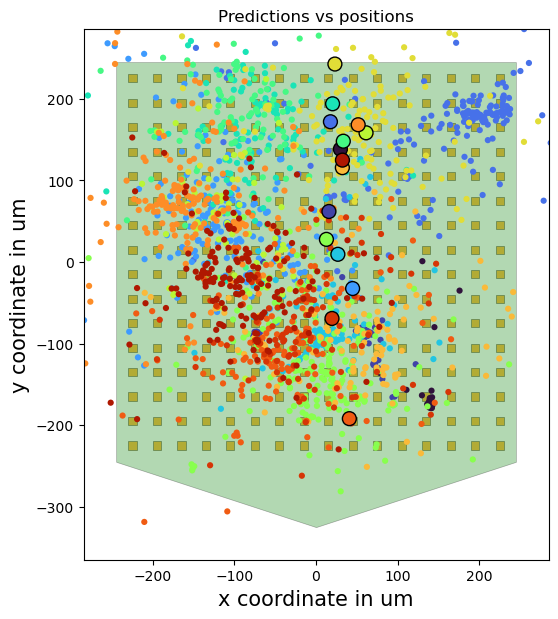

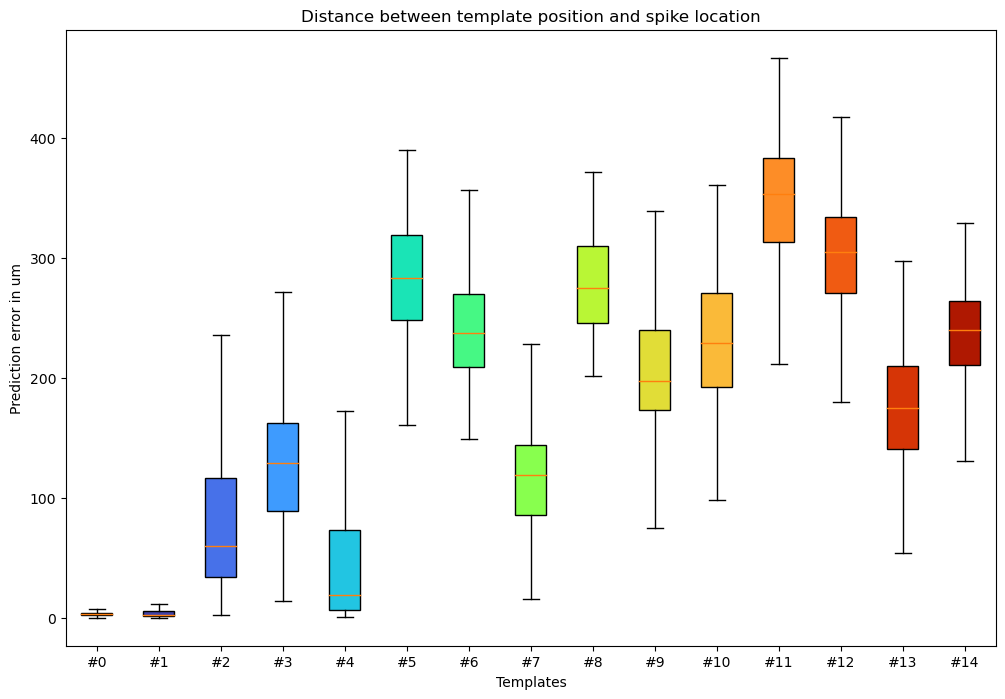

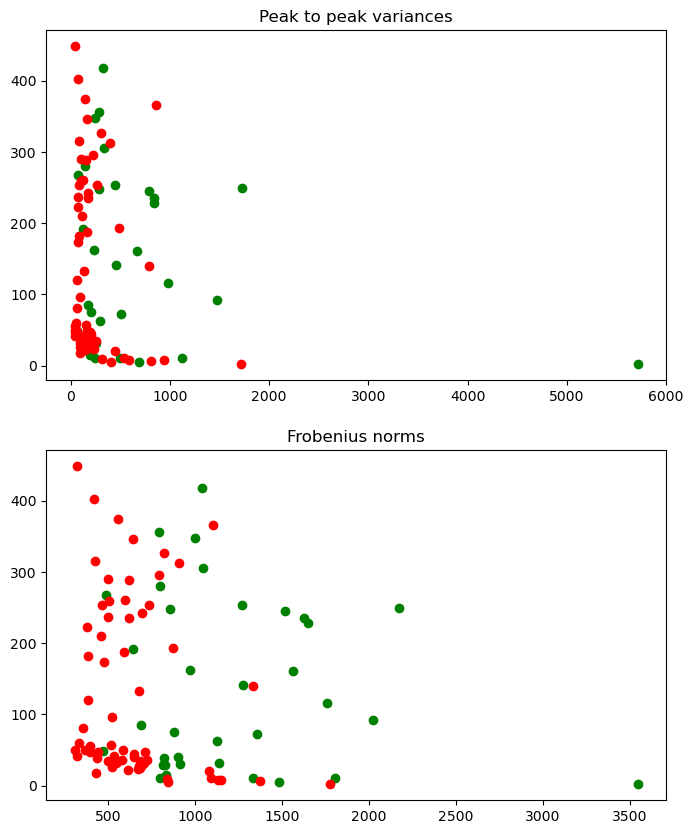

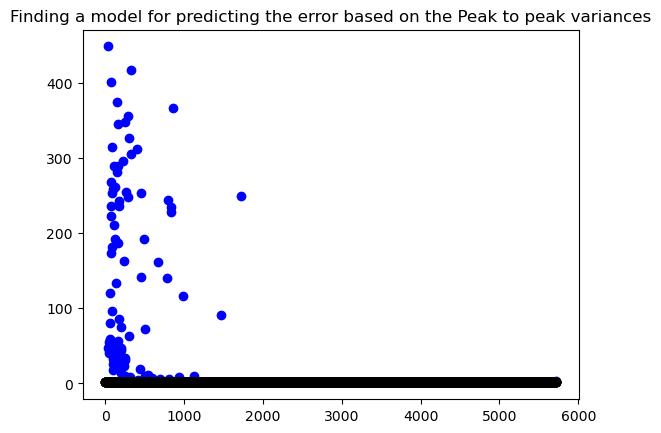

In [72]:
mea_data = artificial_data(files_folder, probe)
print('initialisation done')
mea_data.load_in_spike_interface() 
print('Data loaded in Spike Interface')
mea_data.predicted_locations()
print('Locations predicted')
mea_data.find_errors() 
print('Errors found, plotting starting')
mea_data.plot_predictions()
mea_data.boxplot_errors() 
mea_data.plot_error_against_features()
mea_data.predictor('Peak to peak variances')
mea_data.plot_fit_curve('Peak to peak variances')

In [73]:
class real_data_templates:
    def __init__(self, file, probe) :
        self.file = file 
        self.templates = np.load(file)
        self.templates = np.array(self.templates).T.tolist()
        self.probe = probe

    
    def templates_in_recording (self) :
        self.n_templates = len(self.templates)
        self.template_ids = range(self.n_templates)
        self.n_probes = len(self.templates[0])

    def templates_features(self):
        self.templates_in_recording()
        self.template_infos = {
            'Peak to peak variances' : [] , 'Frobenius norms' : []
        }
        for template_id in self.template_ids :
            ptp = [np.max(self.templates[template_id][probe][:]) - np.min(self.templates[template_id][probe][:]) for probe in range(self.n_probes)]
            self.template_infos['Peak to peak variances'].append(np.var(ptp))
            self.template_infos['Frobenius norms'].append(np.linalg.norm(self.templates[template_id]))

    def predict_error(self, feature, slope, rectification) :
        self.templates_features()
        x_fit = self.template_infos[feature]
        y_fit = [1/(slope*xi+rectification) for xi in x_fit]
        plt.scatter(x_fit, y_fit, color = 'black')
        plt.title(f"Predicting the error based on the {feature} for real data")

In [240]:
class real_data_recordings :
    def __init__(self,folder, probe, rec) :
        self.rec = rec
        self.folder = folder
        self.probe = probe
        recording_si = si.read_mcsraw(f"{folder}recordings\\{rec}\\{rec}.raw")
        recording_si.annotate(is_filtered=True)
        recording_si = recording_si.frame_slice(0,600000) #30 secondes
        self.recording_si = recording_si.set_probegroup(read_prb(f"{folder}\\{probe}.prb"))
        juxta = si.read_binary(f"{folder}recordings\\{rec}\\{rec}.juxta.raw", sampling_frequency=20000, num_chan=1, dtype='float32')
        peaks = detect_peaks(juxta, exclude_sweep_ms=2, detect_threshold=8)
        times = peaks['sample_ind']
        times = np.array([t for t in times if t<600000])
        self.sorting_si = si.NumpySorting.from_times_labels(times, np.zeros(len(times)), sampling_frequency=20000)
        
    def predicted_locations (self, method = 'monopolar_triangulation') :
        wv_real = si.extract_waveforms(recording = self.recording_si, sorting= self.sorting_si, overwrite= False, folder=f"{self.folder}waveforms\\wvReal{self.rec}", load_if_exists=True, max_spikes_per_unit=None)
        self.locations_pred  = si.compute_spike_locations(wv_real, method = method) 
        

    def find_error (self, real_positions) :
        self.locations_real = real_positions
        self.pred_errors = [math.dist((pred[0],pred[1]), self.locations_real) for pred in self.locations_pred]

In [245]:
class multiple_recordings :
    def __init__(self, recording_objects) :
        self.n_recordings = len(recording_objects.keys())
        self.locations_real = [recording_objects[key].locations_real for key in recording_objects.keys()]
        self.locations_pred = [recording_objects[key].locations_pred for key in recording_objects.keys()]
        self.pred_errors = [recording_objects[key].pred_errors for key in recording_objects.keys()]

    def plot_parameters(self) :
        cmap = cm.get_cmap('turbo')
        self.colors = [cmap(c/self.n_recordings) for c in range (self.n_recordings)]
    
    def plot_predictions (self, probe_object) :
        self.plot_parameters()
        #plot_probe(probe_object)
        for rec in range (len(self.locations_real)) :
            x_pred = [pred[0] for pred in self.locations_pred[rec]]
            y_pred = [pred[1] for pred in self.locations_pred[rec]]
            plt.scatter(x_pred, y_pred, s = 20, edgecolors= 'none', color = self.colors[rec]) # the predictions are represented by small dots 
            plt.scatter(self.locations_real[rec][0], self.locations_real[rec][1], s=100, color = self.colors[rec])  
            plt.title('Predictions vs positions')
            plt.xlabel('x coordinate in um')
            plt.ylabel('y coordinate in um')


    def boxplot_errors(self) :
        self.plot_parameters()
        fig = plt.figure(figsize =(12, 8))
        ax = plt.subplot()
        bp = plt.boxplot(self.pred_errors, 0, '', patch_artist=True)
        ax.set_ylabel('Prediction error in um')
        ax.set_xlabel('Recordings')
        ax.set_title('Distance between template position and spike location')
        for patch, color in zip(bp['boxes'], self.colors):
            patch.set_facecolor(color)      
        plt.show()

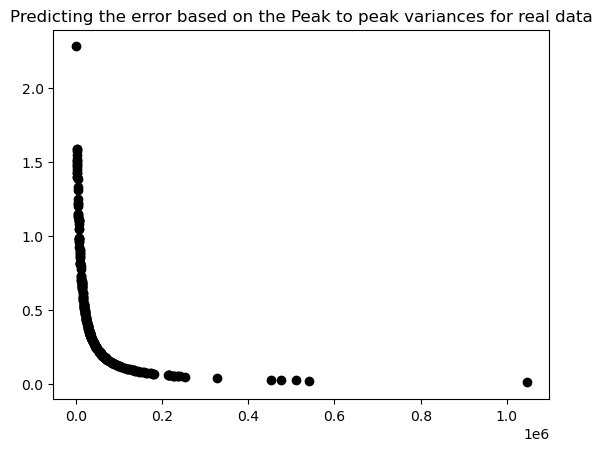

In [110]:
probe ='mea_256'
probe_object = read_prb(f"{working_folder}\\data_real\\{probe}.prb")
physio_templates = real_data_templates(templates_file, probe) 
physio_templates.predict_error('Peak to peak variances', mea_data.slope, mea_data.rectification)

In [241]:
p = probe_object.to_dict()
channel_positions = p['probes'][0]['contact_positions']

real_positions = {'20160426_patch3' : channel_positions[226],
                  '20170726_patch1' : (0.9*channel_positions[30] + 0.1*channel_positions[3]),
                  '20170728_patch2' : channel_positions[118],
                  '20160426_patch2' : channel_positions[200] + [-15, -15], 
                  '20160415_patch2' : (channel_positions[69] + channel_positions[33])/2.}
                  
physio_recordings = {}
for rec in listdir(working_folder + 'data_real\\recordings'): 
    folder = f"{working_folder}data_real\\"
    physio_recordings[rec] = real_data_recordings(folder, probe, rec)
    physio_recordings[rec].predicted_locations()
    physio_recordings[rec].find_error(real_positions[rec])

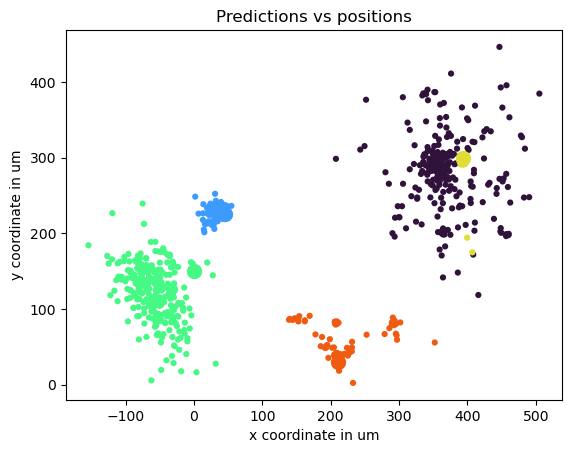

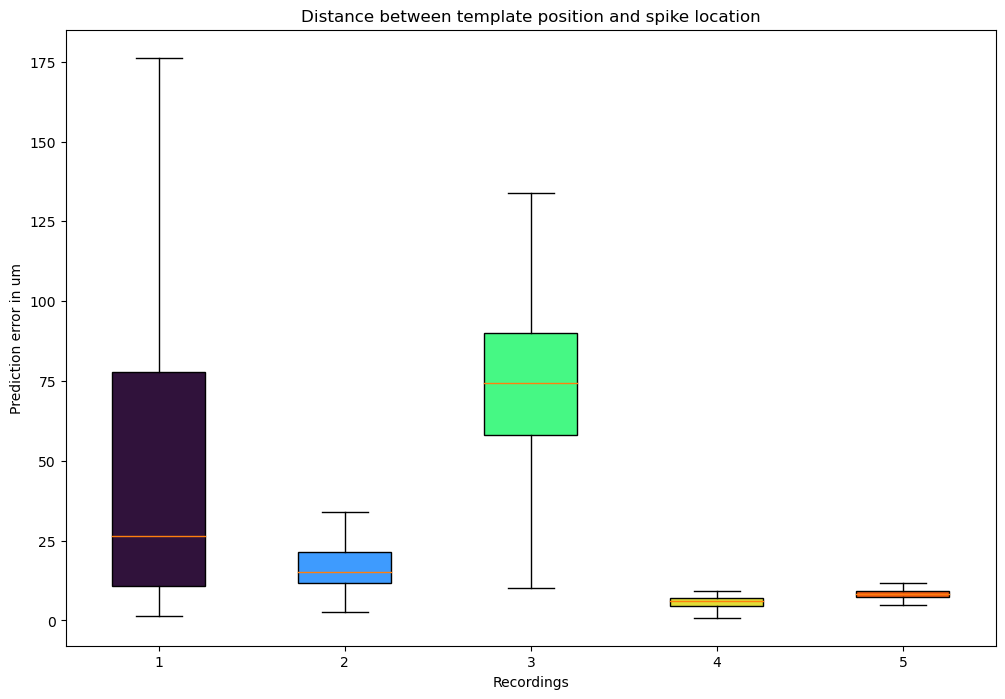

In [246]:
physio_all_recordings = multiple_recordings(physio_recordings)
physio_all_recordings.plot_predictions(probe_object)
physio_all_recordings.boxplot_errors()